### TODO
- states and params share variable names: invalid coord names

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import os
os.environ["pytensor_FLAGS"] = "floatX=float64"

In [3]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pymc as pm
import pytensor
import pytensor.tensor as pt

# this notebook show DEBUG log messages
# logging.getLogger('pymc').setLevel(logging.DEBUG)

import arviz
import IPython.display

WARNING (aesara.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# pymc3.ode: Shapes and benchmarking

### Demo Scenario: Simple enzymatic reaction
The model has two ODEs with 3 parameters in total.

In our generated data, we'll observe `S` and `P` at different times to demonstrate how to slice in such cases.

687 µs ± 6.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


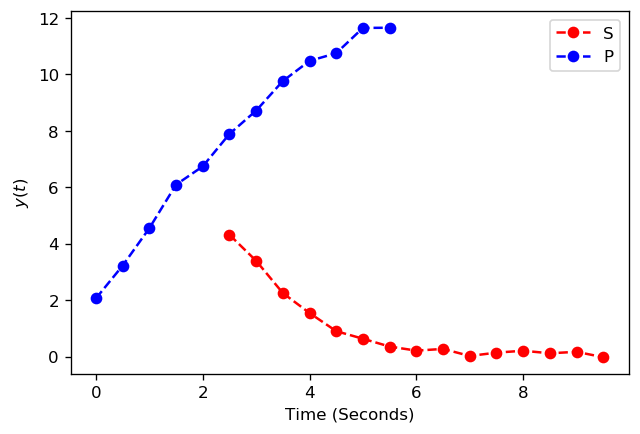

In [8]:
# For reproducibility
np.random.seed(23489)
n_extra = 1

class Chem:
    @staticmethod
    def reaction(y, t, p):
        S, P = y[0], y[1]
        vmax, K_S = p[0], p[1]
        dPdt = vmax * S / (K_S + S)
        dSdt = -dPdt
        return [dSdt, dPdt] + [
            dPdt * p[2:][i] for i in range(n_extra)
        ]

# Times for observation
times = np.arange(0,10,0.5)
red = np.arange(5, len(times))
blue = np.arange(12)
x_obs_1 = times[red]
x_obs_2 = times[blue]

y0_true = (10, 2)
y0_true = y0_true + tuple(np.ones(n_extra))
theta_true = vmax, K_S = (3, 2)
theta_true = theta_true + tuple(np.ones(n_extra))
sigma = 0.2

y_obs = odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
%timeit odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
y_obs_1 = np.random.normal(y_obs[red,0], sigma)
y_obs_2 = np.random.normal(y_obs[blue,1], sigma)

fig, ax = plt.subplots(dpi=120)
plt.plot(x_obs_1, y_obs_1, label='S', linestyle='dashed', marker='o', color='red')
plt.plot(x_obs_2, y_obs_2, label='P', linestyle='dashed', marker='o', color='blue')
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$')
plt.show()

In [9]:
# To demonstrate that test-value computation works, but also for debugging
pytensor.config.compute_test_value = 'raise'
pytensor.config.exception_verbosity = 'high'
pytensor.config.traceback.limit = 5

In [10]:
def reaction_sympy(t, y, p):
    dPdt = p.vmax * y.S / (p.K_S + y.S)
    return {
        'S': -dPdt,
        'P': dPdt,
        'extra': p.extra_p * dPdt,
    }

In [13]:
import sunode.wrappers.as_pytensor


def get_model_sunode():
    with pm.Model() as pmodel:
        sigma = pm.HalfCauchy('sigma', 1)
        vmax = pm.LogNormal('vmax', 0, 1)
        K_S = pm.LogNormal('K_S', 0, 1)
        s0 = pm.Normal('red_0', mu=10, sigma=2)
        extra = pm.Normal('extra', shape=n_extra)

        y_hat, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
            y0={
                'S': (s0, ()),  # TODO Infer shape from model?
                'P': np.array(y0_true[1], dtype='d'),
                'extra': (np.ones(n_extra), n_extra),
            },
            params={
                'K_S': (K_S, ()),
                'vmax': (vmax, ()),
                'tmp': np.zeros(1),  # TODO pytensor wants at least one fixed param
                'extra_p': (extra, (n_extra,))
            },
            rhs=reaction_sympy,
            tvals=times,
            t0=times[0],
        )

        red_hat = y_hat['S'][red]
        blue_hat = y_hat['P'][blue]
        
        pm.Deterministic('solution_S', y_hat['S'])
        pm.Deterministic('solution_P', y_hat['P'])

        Y_red = pm.Normal('Y_red', mu=red_hat, sigma=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sigma=sigma, observed=y_obs_2)

    return pmodel


def get_model_sunode_reparam():
    with pm.Model() as pmodel:
        sigma = pm.HalfCauchy('sigma', 1)
        K_S = pm.LogNormal('K_S', 0, 1)

        # Place a prior over the reaction rate at concentration 5
        # instead of vmax.
        # mu and sd are chosen so that the prior is very similar
        # to the original model.
        c = 5
        log_v = pm.Normal('log_v', mu=-0.22, sigma=1)

        vmax = np.exp(log_v) * (c + K_S) / c
        pm.Deterministic('vmax', vmax)

        s0 = pm.Normal('red_0', mu=10, sigma=2)
        
        extra = pm.Normal('extra', shape=n_extra)

        y_hat, problem, _ = sunode.wrappers.as_pytensor.solve_ivp(
            y0={
                'S': (s0, ()),  # TODO Infer shape from model?
                'P': np.array(y0_true[1], dtype='d'),
                'extra': (np.ones(n_extra), n_extra),
            },
            params={
                'K_S': (K_S, ()),
                'vmax': (vmax, ()),
                'tmp': np.zeros(1),  # TODO pytensor wants at least one fixed param
                'extra_p': (extra, (n_extra,))
            },
            rhs=reaction_sympy,
            tvals=times,
            t0=times[0],
        )

        red_hat = y_hat['S'][red]
        blue_hat = y_hat['P'][blue]
        
        pm.Deterministic('solution_S', y_hat['S'])
        pm.Deterministic('solution_P', y_hat['P'])
        
        Y_red = pm.Normal('Y_red', mu=red_hat, sigma=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sigma=sigma, observed=y_obs_2)

    return pmodel

In [14]:
def get_model():
    with pm.Model() as pmodel:    
        sigma = pm.HalfCauchy('sigma', 1)
        vmax = pm.LogNormal('vmax', 0, 1)
        K_S = pm.LogNormal('K_S', 0, 1)
        s0 = pm.Normal('red_0', mu=10, sigma=2)
        
        extra = pm.Normal('extra', shape=n_extra)

        y_hat = pm.ode.DifferentialEquation(
            func=Chem.reaction,
            times=times,
            n_states=len(y0_true), n_theta=len(theta_true)
        )(
            y0=[s0, y0_true[1]] + list(np.ones(n_extra)),
            theta=[vmax, K_S] + [extra[i] for i in range(n_extra)],
            return_sens=False
        )

        red_hat = y_hat.T[0][red]
        blue_hat = y_hat.T[1][blue]

        Y_red = pm.Normal('Y_red', mu=red_hat, sigma=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sigma=sigma, observed=y_obs_2)

    return pmodel

def make_benchmark(pmodel):    
    # select input variables & test values
    t_inputs = pmodel.cont_vars
    # apply transformations as required
    test_inputs = (np.log(0.2), np.log(0.5), np.log(1.9), 10, np.ones(n_extra))
    
    # create a test function for evaluating the logp value
    print('Compiling f_logpt')
    f_logpt = pytensor.function(
        inputs=t_inputs,
        outputs=[pmodel.logpt],
        # with float32, allow downcast because the forward integration is always float64
        allow_input_downcast=(pytensor.config.floatX == 'float32')
    )
    print(f'Test logpt:')
    print(f_logpt(*test_inputs))
    
    # and another test function for evaluating the gradient
    print('Compiling f_logpt')
    f_grad = pytensor.function(
        inputs=t_inputs,
        outputs=pt.grad(pmodel.logpt, t_inputs),
        # with float32, allow downcast because the forward integration is always float64
        allow_input_downcast=(pytensor.config.floatX == 'float32')
    )
    print(f'Test gradient:')
    print(f_grad(*test_inputs))
    
    # make a benchmarking function that uses random inputs
    # - to avoid cheating by caching
    # - to get a more realistic distribution over simulation times
    vals = [
        np.log(np.random.uniform(0.1, 0.2)),
        np.log(np.random.uniform(0.4, 0.6)),
        np.log(np.random.uniform(1.9, 2.1)),
        np.random.uniform(9, 11),
        np.random.randn(n_extra),
    ]

    def bm_val():
        f_logpt(*vals)
    
    def bm_grad():
        f_grad(*vals)

    return pmodel, bm_val, bm_grad

In [15]:
model, benchmark, benchmark_grad = make_benchmark(get_model())
model_sunode, benchmark_sunode, benchmark_grad_sunode = make_benchmark(get_model_sunode())
model_sunode_reparam = get_model_sunode_reparam()

print('\nPerformance:')
%timeit benchmark()
%timeit benchmark_sunode()
%timeit benchmark_grad()
%timeit benchmark_grad_sunode()

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/aesara/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Aesara. If you encounter problems, try updating Aesara or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Compiling f_logpt
Test logpt:
[array(-12365.93303267)]
Compiling f_logpt
Test gradient:
[array(24728.24539402), array(7984.60038498), array(-1435.26565838), array(-2299.84976284), array([-1.])]


ValueError: too many values to unpack (expected 3)

In [10]:
with model_sunode:
    idata = pm.sample(draws=1000, cores=8, chains=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [extra, red_0, K_S, vmax, sigma]


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8922921479904536, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888597508329236, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8923642877007875, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883988623460374, but should be close to 0.8. Try to increase the number of tuning steps.


In [11]:
with model_sunode_reparam:
    idata_trafo = pm.sample(draws=1000, cores=8, chains=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [extra, red_0, log_v, K_S, sigma]


The acceptance probability does not match the target. It is 0.8998782874557476, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882638315374893, but should be close to 0.8. Try to increase the number of tuning steps.


## Compare the original model with the reparametrization

In [12]:
import arviz
import xarray as xr
import seaborn as sns

In [13]:
traces = xr.concat([idata.posterior, idata_trafo.posterior], dim='model')

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


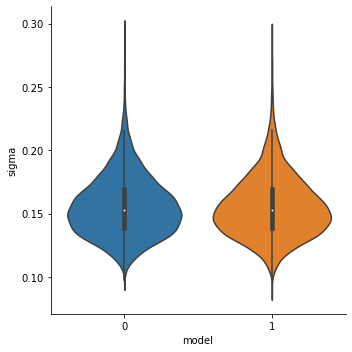

In [14]:
sns.factorplot('model', 'sigma', data=traces.sigma.to_dataframe().reset_index(), kind='violin')

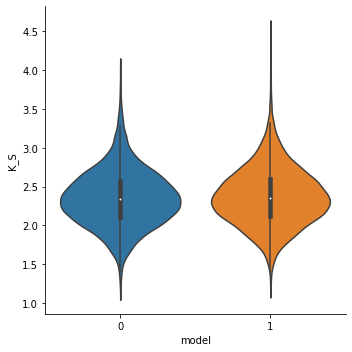

In [15]:
sns.factorplot('model', 'K_S', data=traces.K_S.to_dataframe().reset_index(), kind='violin')

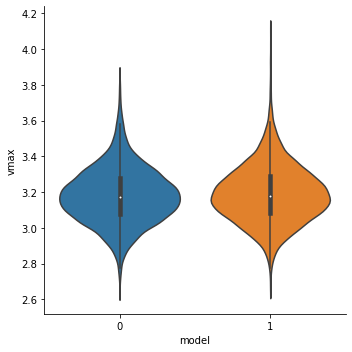

In [16]:
sns.factorplot('model', 'vmax', data=traces.vmax.to_dataframe().reset_index(), kind='violin')

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

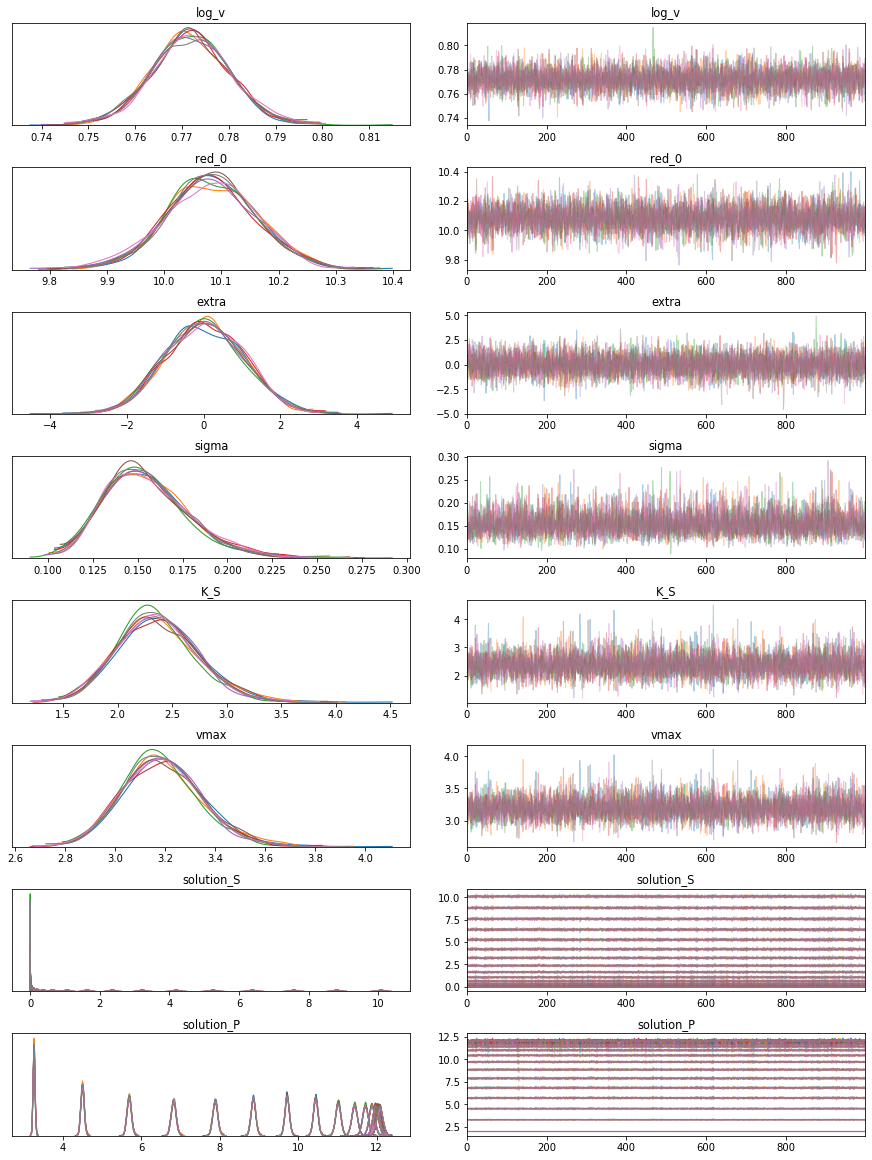

In [17]:
az.plot_trace(idata_trafo);

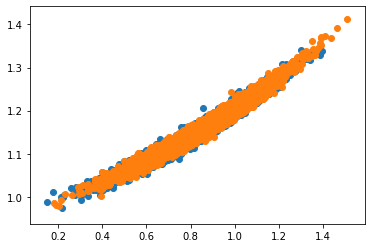

In [18]:
pst = idata.posterior.stack(sample=("chain", "draw"))
pst_trafo = idata_trafo.posterior.stack(sample=("chain", "draw"))

a = np.log(pst['K_S'])
b = np.log(pst['vmax'])
plt.scatter(a, b)

a = np.log(pst_trafo['K_S'])
b = np.log(pst_trafo['vmax'])
plt.scatter(a, b)

In [19]:
plt.plot(pst['y_hat'][0])
plt.plot(pst['y_hat'][-1])
plt.plot(pst['y_hat'][-100])

KeyError: 'Unknown variable y_hat'

### Why the reparametrization?

This doesn't look so great:

In [ ]:
a = np.log(pst['K_S'])
b = np.log(pst['vmax'])
plt.scatter(a, b)

If we use the reaction rate for c == 5 instead of vmax, this looks much better:

In [ ]:
c = 5
a = np.log(pst['K_S'])
b = np.log(pst['vmax'] * c / (c + pst['K_S']))
plt.scatter(a, b)

We try to find a distribution for v(5) that results to a similar prior on vmax as the original:

In [ ]:
with model_sunode:
    prior = pm.sample_prior_predictive().prior
with model_sunode_reparam:
    prior_trafo = pm.sample_prior_predictive().prior

In [ ]:
c = 5
prior_v = prior['vmax'] * c / (c + prior['K_S'])
prior_trafo_v = prior['vmax'] * c / (c + prior['K_S'])

In [ ]:
np.log(prior_v).mean(), np.log(prior_v).std()

In [ ]:
plt.scatter(np.log(prior_v), np.log(prior['K_S']))
plt.scatter(np.log(prior_trafo['vmax']), np.log(prior_trafo['K_S']))

### Investigate the trafo a bit :-)

In [ ]:
import sympy as sym

In [ ]:
log_vmax, log_K = sym.symbols('log_v_max, log_K', real=True)
#vmax, K = sym.symbols('v_max, K', positive=True)
c = sym.Symbol('c', positive=True)

vmax = sym.exp(log_vmax)
K = sym.exp(log_K)

v = vmax * c / (c + K)
log_v = sym.log(v)
dv = v.diff(c)
log_dv = sym.log(dv)

In [ ]:
m = sym.Matrix([log_v, log_K])
m.simplify()
m

In [ ]:
(sym.Matrix([log_v, log_dv]).jacobian(sym.Matrix([log_vmax, log_K])).det()).simplify()

In [ ]:
c = sym.symbols('c', positive=True)
log_sd, x = sym.symbols('log_sd, x', real=True)

sd = sym.exp(log_sd)


In [ ]:
func = sym.lambdify([log_vmax, log_K, c], [log_vmax, log_K])

lv, ldv = func(np.arange(-5, 5)[None, :], np.linspace(-5, 10)[:, None], 5)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='blue');

lv, ldv = func(np.linspace(-5, 5)[:, None], np.arange(-5, 10)[None, :], 5)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='red');

plt.xlabel('log_vmax')
plt.ylabel('log_K');

In [ ]:
func = sym.lambdify([log_vmax, log_K, c], [log_v, log_K])
lv, ldv = func(np.arange(-5, 5)[None, :], np.linspace(-5, 10)[:, None], 10)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='blue');

lv, ldv = func(np.linspace(-5, 5)[:, None], np.arange(-5, 10)[None, :], 10)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='red');

plt.xlabel('log_v')
plt.ylabel('log_K');

In [ ]:
c = np.linspace(0, 15)[:, None, None]
K_S = np.array([3, 4, 5])[None, :, None]
vmax = np.array([0.1, 0.2, 0.3])[None, None, :]
vals = (vmax * c) / (c + K_S)
#plt.plot((vmax * c) / (c + K_S))

In [ ]:
n_subplots = len(vmax.ravel())
fig, axes = plt.subplots(1, n_subplots, figsize=(13, 4), sharex=True, sharey=True)
#plt.plot(vals[:, 0, 1])
for i in range(n_subplots):
    axes[i].plot(vals[:, :, i])

### Inspecting the computation graphs
If you zoom in to the large `DifferentialEquation` ellipse in the top, you can follow the blue arrows downwards to see that the gradient is directly passed from the original DifferentialEquation Op node.

In [ ]:
pytensor.printing.pydotprint(pt.grad(model_sunode.logpt, model_sunode.vmax), 'ODE_API_shapes_and_benchmarking.png')
IPython.display.Image('ODE_API_shapes_and_benchmarking.png')

With the cell below, you can visualize the computation graph interactively. (The HTML file is saved next to this notebook.)

If you need to install `graphviz/pydot`, you can use these commands:
```
conda install -c conda-forge python-graphviz
pip install pydot
```

In [9]:
from pytensor import d3viz
d3viz.d3viz(model.logpt, 'ODE_API_shapes_and_benchmarking.html')